---
**<h1><center> </center></h1>**

**<h1><center> Proyecto: Clasificación de etapa de maduración del cacao </center></h1>**

**<h2><center> Visión Artificial - 2024-2</center></h2>**

<center><img src="https://upload.wikimedia.org/wikipedia/commons/c/c4/Escudo_unal_2016.png" width="100"></center>

---
<center>

<h1> Integrantes: </h1>


Sebastian Gomez Zapata: segomezz@unal.edu.co

Harrison Zuleta Montoya : hzuletam@unal.edu.co

Mateo Sanchez : matsanchez@unal.edu.co

Isaac Luna Herrera : ilunah@unal.edu.co

David Castrillón Vallejo : dacastrillon@unal.edu.co



</center>

# Contexto del problema

El cacao es uno de los cultivos más importantes a nivel mundial, tanto por su valor económico como por su rol cultural y social, especialmente en países tropicales donde es una fuente vital de ingresos para millones de agricultores. Este cultivo es la base para la producción de chocolate, un producto ampliamente consumido globalmente. Sin embargo, el proceso de cosecha del cacao enfrenta varios desafíos, uno de los cuales es determinar el momento adecuado para recolectar los frutos. Si los frutos se cosechan demasiado temprano o demasiado tarde, pueden perder calidad, lo que afecta el sabor, el rendimiento y, en última instancia, la rentabilidad del cultivo. La falta de automatización en la clasificación de la maduración del cacao obliga a los agricultores a depender de métodos manuales, que son lentos, propensos a errores humanos y requieren una gran cantidad de mano de obra. Este enfoque tradicional no solo reduce la eficiencia, sino que también aumenta el riesgo de cosechar frutos en la etapa incorrecta, lo que puede generar pérdidas económicas significativas y afectar la calidad del grano.

En este contexto, generar un modelo de visión artificial para predecir el nivel de maduración del fruto de cacao se vuelve fundamental para optimizar los procesos agrícolas y mejorar la calidad del cacao producido. Este modelo permitiría automatizar la clasificación de los frutos en sus diferentes etapas de maduración, lo que facilitaría la cosecha en el momento óptimo. Un manejo adecuado de la cosecha es esencial para garantizar la calidad del grano y maximizar los rendimientos. Además, al automatizar este proceso, se reduce el error humano y se incrementa la eficiencia en el campo, permitiendo a los agricultores tomar decisiones más precisas y basadas en datos. Esto no solo mejoraría la productividad, sino que también contribuiría a la sostenibilidad del cultivo, ya que se podrían reducir desperdicios y pérdidas de cosechas no maduras o sobre-maduras.

# Procedimiento Empleado

### Importación de librerías y preparación de imágenes

Primero se comenzará importando todas las librerías necesarias

In [23]:
import os
import random
import json
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.image import imread
from ultralytics import YOLO
import zipfile
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

* Ahora se procede a descomprimir el dataset y mostramos una imagen de forma aleatoria

In [ ]:
zip_path = '/Users/sebastiangomezzapata/Universidad/Semestre 2024-II/Visión Artificial/Proyecto Clasificación Cacao/RipSetCocoaCNCH12 (1).zip'
unzip_dir = '/Users/sebastiangomezzapata/Universidad/Semestre 2024-II/Visión Artificial/Proyecto Clasificación Cacao/Dataset'

# Crear el directorio si no existe
if not os.path.exists(unzip_dir):
    os.makedirs(unzip_dir)

# Descomprimir el archivo
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)
    print("Dataset descomprimido exitosamente")

Mostrando imagen aleatoria: /Users/sebastiangomezzapata/Universidad/Semestre 2024-II/Visión Artificial/Proyecto Clasificación Cacao/Dataset/RipSetCocoaCNCH12/COCO_10/images_C3/20221212_101112.jpg


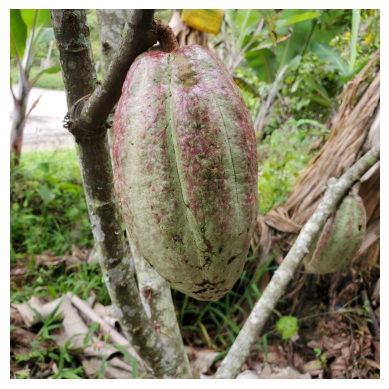

In [22]:
unzip_dir = '/Users/sebastiangomezzapata/Universidad/Semestre 2024-II/Visión Artificial/Proyecto Clasificación Cacao/Dataset'
# Listar todas las imágenes en la carpeta descomprimida
image_extensions = ('.jpg', '.jpeg', '.png')
image_files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(unzip_dir)
               for f in filenames if f.lower().endswith(image_extensions)]

# Verificar si se encontraron imágenes
if not image_files:
    print("No se encontraron imágenes en el archivo descomprimido.")
else:
    # Seleccionar una imagen aleatoria
    random_image_path = random.choice(image_files)
    print(f"Mostrando imagen aleatoria: {random_image_path}")

    # Mostrar la imagen
    image = Image.open(random_image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

Una vez el dataset haya sido descomprimido y todas las librerías han sido importadas se comienzan a desarrollar el pipeline 

## 1) Adquisición de la imagen


<img src="/Users/sebastiangomezzapata/Universidad/Semestre 2024-II/Visión Artificial/Proyecto Clasificación Cacao/Proyecto-clasificacion-de-cacao/Adquisición de la imagen.png" width="767" height="327">



El proceso de adquisición de la imagen se obtuvo del dataset RipSetCocoaCNCH12<sup>1</sup>. A continuación se indica las especificaciones de los dipostivos utilizados para la adquisición de la imagen.



| Smartphone | Camera Specifications |
|------------|---------------------|
| Samsung Galaxy A01 | Dual rear camera consisting of a 13-megapixel f/2.0 main sensor and a 2-megapixel f/2.4 depth sensor. |
| Samsung Galaxy Note 10 | Triple camera composed of an ultra-wide angle: 16 MP, f/2.2, 123°; a wide angle: 12 MP, AF, f/1.5-2.4; and a phone Camera: 12 MP, f/2.1. |
| iPhone SE 2020 | Single camera. 12 MP wide-angle camera, f/1.8 aperture. |
| LG G5 | Dual camera. 16 MP main camera and f/1.8 aperture.8MP secondary super-wide-angle camera with f/2.4 aperture. |
| Motorola G9 plus | Quadruple camera. Main camera: 64 MP sensor, f/1.8 aperture and phase detection focus. Ultra-angular: 8 MP sensor, f/2.2 aperture. Macro: 2 MP sensor and f/2.2 aperture. Depth: 2 MP sensor and f/2.2 aperture. |

En el artículo "RipSetCocoaCNCH12: Labeled Dataset for Ripeness Stage Detection, Semantic and Instance Segmentation of Cocoa Pods" <sup>2</sup>, se describe que:
"Las imágenes fueron tomadas entre las 8:00 a.m. y las 4:00 p.m. Primero, se ajustó el formato de tamaño para la captura en todos los smartphones a una relación 1:1, y luego se les aplicó un redimensionamiento utilizando un script en lenguaje Python con Pillow (Python Imaging Library), dándoles un tamaño final de 3000 × 3000 px. Las imágenes originales tenían tamaños en el rango de 3072 × 3072 a 4096 × 4096 px."

### 1.1) Análisis de dataset

El dataset RipSetCocoaCNCH12 fue desarrollado por la Compañía Nacional de Chocolates y recopila imágenes de la variedad de cacao CNCH12 en la finca de la compañía ubicada en el municipio de Támesis, Antioquia, Colombia (5°43′02″ N, 75°41′25″ W), a una altitud promedio de 1100 m. Las imágenes fueron tomadas durante la principal temporada de cosecha, entre el 1 de diciembre de 2022 y el 17 de febrero de 2023.

El período promedio de maduración de las mazorcas de cacao es de 6 a 7 meses, aunque puede variar según las condiciones agronómicas y climáticas. Los agrónomos definieron las etapas de madurez en rangos de dos meses, basándose en diferencias físicas y químicas. Las imágenes se clasificaron en cinco clases según la madurez de las mazorcas:

1.	Clase 1 (0–2 meses)
2.	Clase 2 (2–4 meses)
3.	Clase 3 (4–6 meses)
4.	Clase 4 (>6 meses)
5.	Clase A (Abortos): Mazorcas que iniciaron su crecimiento pero murieron por plagas, enfermedades o problemas fisiológicos.

El dataset contiene dos carpetas principales:
1.	Anotaciones en formato COCO 1.0.
2.	Imágenes en formato de máscara de segmentación 1.1.

Las imágenes están organizadas en subcarpetas por clase predominante, aunque una imagen puede contener instancias de varias clases.

Finalmente se puede observar en esta tabla el número de clases.

| Clase | Nombre de clase           | Instancias |
|-------|-----------------------|-----------|
| C1    | Clase 1 (0–2 meses)  | 3278      |
| C2    | Clase 2 (2–4 meses)  | 1688      |
| C3    | Clase 3 (4–6 meses)  | 1519      |
| C4    | Clase (>6 meses) | 1169   |
| CA    | Abortos             | 263       |
| **Total** |                   | **7917**  |

El dataset ocupa un espacio de 27 gb por lo cual se hará una copia en google drive para que se pueda acceder remotamente y de igual manera se trabajara con el de forma local. Ahora vamos a mostrar aleatoriamente una imagen de cada clase

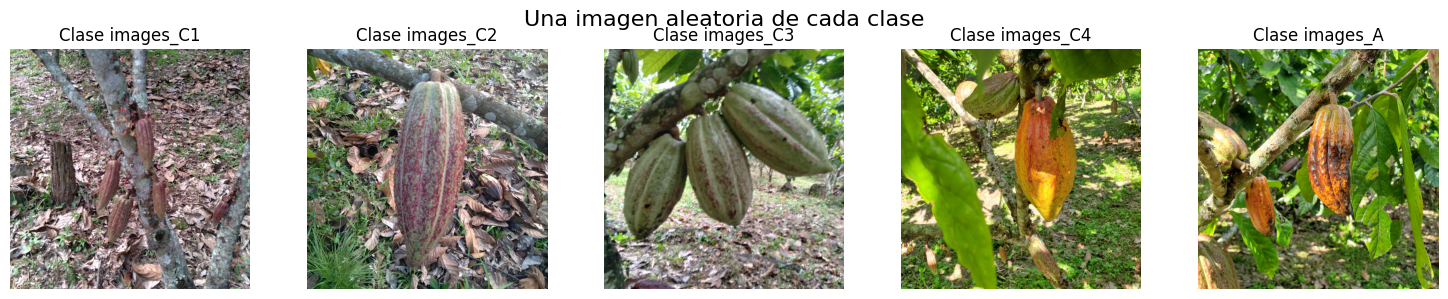

In [24]:
carpeta_principal = "/Users/sebastiangomezzapata/Universidad/Semestre 2024-II/Visión Artificial/Proyecto Clasificación Cacao/Dataset/RipSetCocoaCNCH12/COCO_10"  # Ajusta esta ruta si es necesario

# Crear figura y ejes para el subplot
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
fig.suptitle("Una imagen aleatoria de cada clase", fontsize=16)

# Iterar sobre las subcarpetas c1-c5
for i, clase in enumerate(['images_C1', 'images_C2', 'images_C3', 'images_C4', 'images_A']):
    # Construir la ruta a la subcarpeta
    ruta_subcarpeta = os.path.join(carpeta_principal, clase)
    
    # Obtener lista de archivos jpg en la subcarpeta
    archivos_jpg = [f for f in os.listdir(ruta_subcarpeta) if f.endswith('.jpg')]
    
    if archivos_jpg:
        # Seleccionar un archivo al azar
        archivo_aleatorio = random.choice(archivos_jpg)
        
        # Construir la ruta completa al archivo
        ruta_imagen = os.path.join(ruta_subcarpeta, archivo_aleatorio)
        
        # Leer y mostrar la imagen en el subplot correspondiente
        img = imread(ruta_imagen)
        axes[i].imshow(img)
        axes[i].set_title(f'Clase {clase}')
        axes[i].axis('off')  # Ocultar los ejes
    else:
        axes[i].text(0.5, 0.5, f'No hay imágenes JPG en {clase}', 
                    ha='center', va='center')
        axes[i].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Ajustar para que el título principal no se superponga
plt.show()

## 2) Procesamiento

<img src="/Users/sebastiangomezzapata/Universidad/Semestre 2024-II/Visión Artificial/Proyecto Clasificación Cacao/Proyecto-clasificacion-de-cacao/Procesamiento.png" width="767" height="327">

En el artículo base del dataset no hablan específicamente de que técnicas o métodos utilizaron para el procesamiento, pero debido a que el dataset ya se encuentra totalmente segmentado se continuará con el pipeline 

## 3) Segmentación

<img src="/Users/sebastiangomezzapata/Universidad/Semestre 2024-II/Visión Artificial/Proyecto Clasificación Cacao/Proyecto-clasificacion-de-cacao/Segmentación.png" width="767" height="327">

Como se explicó previamente el dataset contiene una carpeta llamada Segmentation_Mask_11, la cual contiene 20 carpetas divididas de las siguiente manera
* 5 carpetas para la segmentation_object_* donde estan las segmentaciones de los objetos, una carpeta por cada una de las clases
* 5  carpetas para la segmentation_class_* donde estan las segmentaciones de las clases, una carpeta por cada una de las clases
* 5  carpetas llamadas JPGImages_* para la imagenes reales, una carpeta por cada clase
* 5 carpetas llamadas ImagesSets_* donde se encuentra un archivo de texto con el nombre de cada una de las fotos tomadas a las imagenes de esa clase

Ahora se mostraran aleatoriamente la segmentación de cada una de las clases

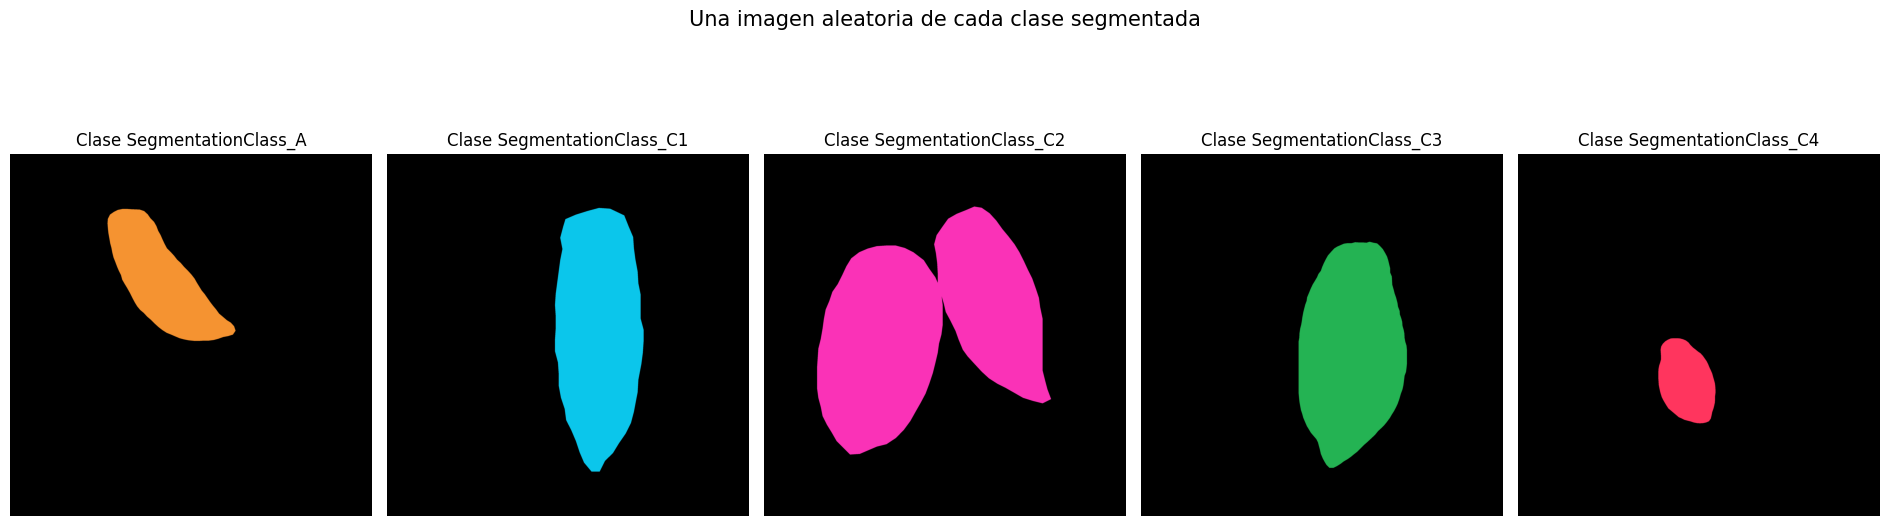

In [29]:
carpeta_principal = "/Users/sebastiangomezzapata/Universidad/Semestre 2024-II/Visión Artificial/Proyecto Clasificación Cacao/Dataset/RipSetCocoaCNCH12/Segmentation_mask_11"  # Ajusta esta ruta si es necesario

# Crear figura y ejes para el subplot
fig, axes = plt.subplots(1, 5, figsize=(19, 6))
fig.suptitle("Una imagen aleatoria de cada clase segmentada", fontsize=15)

# Iterar sobre las subcarpetas c1-c5
for i, clase in enumerate(['SegmentationClass_A', 'SegmentationClass_C1', 'SegmentationClass_C2', 'SegmentationClass_C3', 'SegmentationClass_C4']):
    # Construir la ruta a la subcarpeta
    ruta_subcarpeta = os.path.join(carpeta_principal, clase)
    
    # Obtener lista de archivos jpg en la subcarpeta
    archivos_jpg = [f for f in os.listdir(ruta_subcarpeta) if f.endswith('.png')]
    
    if archivos_jpg:
        # Seleccionar un archivo al azar
        archivo_aleatorio = random.choice(archivos_jpg)
        
        # Construir la ruta completa al archivo
        ruta_imagen = os.path.join(ruta_subcarpeta, archivo_aleatorio)
        
        # Leer y mostrar la imagen en el subplot correspondiente
        img = imread(ruta_imagen)
        axes[i].imshow(img)
        axes[i].set_title(f'Clase {clase}')
        axes[i].axis('off')  # Ocultar los ejes
    else:
        axes[i].text(0.5, 0.5, f'No hay imágenes JPG en {clase}', 
                    ha='center', va='center')
        axes[i].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Ajustar para que el título principal no se superponga
plt.show()

## 4) Extracción de características

<img src="/Users/sebastiangomezzapata/Universidad/Semestre 2024-II/Visión Artificial/Proyecto Clasificación Cacao/Proyecto-clasificacion-de-cacao/Extracción.png" width="767" height="327">

En este apartado es donde entra la segunda gran carpeta del dataset llamada COCO_10. En esta carpeta , se encuentran alojados archivos en formato *.json que serán usados en la siguiente etapa para la detección de bounding boxes y polígonos. COCO_10 consta de 6 carpetas, 5 carpetas que contienen las imágenes de cada una de las clases y una adicional que se llama annotations. Esta última carpeta contiene 5 archivos llamados instances_default_ *.json donde se encuentran las características de cada una de las clases de cacao

## 5) Clasificación y reconocimiento de patrones

<img src="/Users/sebastiangomezzapata/Universidad/Semestre 2024-II/Visión Artificial/Proyecto Clasificación Cacao/Proyecto-clasificacion-de-cacao/Clasificación.png" width="767" height="327">

Finalmente con el dataset segmentado y todas las características en los archivos json se procederá a clasificar las imagenes en sus respectivas clases, para lograr esto se utilizarán  redes neuronales convolucionales, especificamente yolov8 y algoritmos mas ligeros como knn y random forest

### Algoritmo de K-nearest neighbors (KNN)

Este algoritmo no procesa imágenes directamente, por lo que necesitamos convertir las imágenes en vectores de características, con base en la carpeta annotations que donde se encuentran los json con la extracción de características

In [6]:
# Directorio donde están los JSON
json_dir = "/Users/sebastiangomezzapata/Universidad/Semestre 2024-II/Visión Artificial/Proyecto Clasificación Cacao/annotations"

# Diccionario para mapear clases a índices numéricos
class_mapping = {"C1": 0, "C2": 1, "C3": 2, "C4": 3, "A": 4}

X = []
y = []

# Procesar cada archivo JSON en la carpeta
for json_file in os.listdir(json_dir):
    if json_file.endswith(".json"):  # Solo procesar archivos JSON
        json_path = os.path.join(json_dir, json_file)
        print(f"Procesando: {json_path}")

        with open(json_path, "r") as f:
            data = json.load(f)

        # Crear diccionario de imágenes
        image_dict = {img["id"]: img for img in data["images"]}

        # Procesar anotaciones
        for annotation in data["annotations"]:
            image_id = annotation["image_id"]

            if image_id not in image_dict:
                print(f"⚠️ Advertencia: image_id {image_id} no encontrado en images.")
                continue

            width, height = image_dict[image_id]["width"], image_dict[image_id]["height"]
            bbox = annotation["bbox"]  # (x, y, ancho, alto)

            # Normalizar bounding box
            x_norm = bbox[0] / width
            y_norm = bbox[1] / height
            w_norm = bbox[2] / width
            h_norm = bbox[3] / height

            features = [x_norm, y_norm, w_norm, h_norm]
            category_id = annotation["category_id"]

            X.append(features)
            y.append(category_id)

X = np.array(X)
y = np.array(y)

print("✅ Características extraídas correctamente.")
print("Ejemplo de vector de características:", X[0])

Procesando: /Users/sebastiangomezzapata/Universidad/Semestre 2024-II/Visión Artificial/Proyecto Clasificación Cacao/annotations/instances_default_C4.json
Procesando: /Users/sebastiangomezzapata/Universidad/Semestre 2024-II/Visión Artificial/Proyecto Clasificación Cacao/annotations/instances_default_C2.json
Procesando: /Users/sebastiangomezzapata/Universidad/Semestre 2024-II/Visión Artificial/Proyecto Clasificación Cacao/annotations/instances_default_C3.json
Procesando: /Users/sebastiangomezzapata/Universidad/Semestre 2024-II/Visión Artificial/Proyecto Clasificación Cacao/annotations/instances_default_A.json
Procesando: /Users/sebastiangomezzapata/Universidad/Semestre 2024-II/Visión Artificial/Proyecto Clasificación Cacao/annotations/instances_default_C1.json
✅ Características extraídas correctamente.
Ejemplo de vector de características: [    0.35549     0.34202     0.31482     0.49495]


In [17]:
# Dividir dataset en 80% entrenamiento y 20% validación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar KNN con k=5
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Evaluar
y_pred = knn.predict(X_test)
print("🔹 KNN Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test,y_pred, target_names=class_mapping.keys()))

🔹 KNN Accuracy: 0.5797011207970112
              precision    recall  f1-score   support

          C1       0.73      0.87      0.79       691
          C2       0.40      0.38      0.39       336
          C3       0.41      0.44      0.42       284
          C4       0.50      0.33      0.40       243
           A       0.00      0.00      0.00        52

    accuracy                           0.58      1606
   macro avg       0.41      0.40      0.40      1606
weighted avg       0.55      0.58      0.56      1606



In [19]:
from sklearn.svm import SVC

# Entrenar SVM con kernel lineal
svm = SVC(kernel="linear")
svm.fit(X_train, y_train)

# Evaluar
y_pred = svm.predict(X_test)
print("🔹 SVM Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test,y_pred, target_names=class_mapping.keys()))

🔹 SVM Accuracy: 0.5485678704856787
              precision    recall  f1-score   support

          C1       0.73      0.90      0.80       691
          C2       0.35      0.54      0.43       336
          C3       0.33      0.29      0.31       284
          C4       0.00      0.00      0.00       243
           A       0.00      0.00      0.00        52

    accuracy                           0.55      1606
   macro avg       0.28      0.34      0.31      1606
weighted avg       0.45      0.55      0.49      1606



/Users/sebastiangomezzapata/Universidad/Semestre 2024-II/Visión Artificial/Proyecto Clasificación Cacao/newenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sebastiangomezzapata/Universidad/Semestre 2024-II/Visión Artificial/Proyecto Clasificación Cacao/newenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sebastiangomezzapata/Universidad/Semestre 2024-II/Visión Artificial/Proyecto Clasificación Cacao/newenv/lib/python3.13/site-packages/sklearn/metrics/_classi

In [20]:
from sklearn.ensemble import RandomForestClassifier

# Entrenar Random Forest con 100 árboles
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluar
y_pred = rf.predict(X_test)
print("🔹 Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test,y_pred, target_names=class_mapping.keys()))

🔹 Random Forest Accuracy: 0.6027397260273972
              precision    recall  f1-score   support

          C1       0.75      0.89      0.82       691
          C2       0.48      0.35      0.41       336
          C3       0.41      0.46      0.43       284
          C4       0.47      0.43      0.45       243
           A       0.00      0.00      0.00        52

    accuracy                           0.60      1606
   macro avg       0.42      0.43      0.42      1606
weighted avg       0.57      0.60      0.58      1606



Ahora se procederá a instalar yolov8 para su posterior uso

In [2]:
!pip install ultralytics
from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.7/914.7 kB 3.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 1.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 MB 1.8 MB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 6.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.2
    Uninstalling numpy-2.2.2:
      Successfully uninstalled numpy-2.2.2

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/Users/sebastiangomezzapata/Library/Application S

### Corrección de Json

De acuerdo a los json proporcionados, estos no pueden ser entendidos por yolo, por lo cual se debe cambiar los json y organizarlos en dos carpetas que de labels e images para que el aprendizaje supervisado pueda ser entendido por yolov, a lo cual se procede a continuación.
En este primer fragmento de código se establecen las rutas de destino

In [40]:
import os
import json
import shutil
import random

# Rutas base
base_dir = "/Users/sebastiangomezzapata/Universidad/Semestre 2024-II/Visión Artificial/Proyecto Clasificación Cacao"
json_dir = os.path.join(base_dir, "annotations")

# Carpetas de imágenes por clase
image_dirs = {
    "C1": os.path.join(base_dir, "Dataset/RipSetCocoaCNCH12/COCO_10/images_C1"),
    "C2": os.path.join(base_dir, "Dataset/RipSetCocoaCNCH12/COCO_10/images_C2"),
    "C3": os.path.join(base_dir, "Dataset/RipSetCocoaCNCH12/COCO_10/images_C3"),
    "C4": os.path.join(base_dir, "Dataset/RipSetCocoaCNCH12/COCO_10/images_C4"),
    "A": os.path.join(base_dir, "Dataset/RipSetCocoaCNCH12/COCO_10/images_A")
}

# Directorios de salida para YOLO
output_dir = "/Users/sebastiangomezzapata/Universidad/Semestre 2024-II/Visión Artificial/Proyecto Clasificación Cacao/dataset-yolo"
for split in ["train", "val"]:
    os.makedirs(f"{output_dir}/images/{split}", exist_ok=True)
    os.makedirs(f"{output_dir}/labels/{split}", exist_ok=True)

# Dividir imágenes en entrenamiento y validación (80% train, 20% val)
split_ratio = 0.8

def convert_coco_to_yolo(json_file, class_name):
    """ Convierte anotaciones COCO a YOLO y organiza las imágenes en la estructura correcta """
    with open(json_file, 'r') as f:
        data = json.load(f)

    images_info = {img["id"]: img for img in data["images"]}
    annotations = data["annotations"]
    
    # Lista de imágenes para dividir en train/val
    image_filenames = [img["file_name"] for img in data["images"]]
    random.shuffle(image_filenames)
    split_index = int(len(image_filenames) * split_ratio)
    train_images = set(image_filenames[:split_index])
    
    for ann in annotations:
        img_id = ann["image_id"]
        img_info = images_info[img_id]
        img_name = img_info["file_name"]
        width, height = img_info["width"], img_info["height"]

        # Normalizar coordenadas para YOLO
        x, y, w, h = ann["bbox"]
        x_center, y_center = (x + w / 2) / width, (y + h / 2) / height
        w, h = w / width, h / height
        class_id = ann["category_id"] - 1  # Clases desde 0 en YOLO

        # Crear anotación YOLO
        yolo_annotation = f"{class_id} {x_center} {y_center} {w} {h}\n"

        # Determinar el split (train o val)
        split = "train" if img_name in train_images else "val"

        # Mover imagen a la carpeta correspondiente
        img_src = os.path.join(image_dirs[class_name], img_name)
        img_dest = os.path.join(output_dir, "images", split, img_name)
        if os.path.exists(img_src):
            shutil.copy(img_src, img_dest)

        # Guardar anotaciones en formato YOLO
        label_dest = os.path.join(output_dir, "labels", split, img_name.replace(".jpg", ".txt"))
        with open(label_dest, "w") as f:
            f.write(yolo_annotation)

# Procesar todas las clases
json_files = {
    "C1": "instances_default_C1.json",
    "C2": "instances_default_C2.json",
    "C3": "instances_default_C3.json",
    "C4": "instances_default_C4.json",
    "A": "instances_default_A.json"
}

for class_name, json_file in json_files.items():
    convert_coco_to_yolo(os.path.join(json_dir, json_file), class_name)

Ahora en se sobreescribe en yaml_path las rutas de train y val para que yolov lo pueda entender

In [41]:
yaml_path = "/Users/sebastiangomezzapata/Universidad/Semestre 2024-II/Visión Artificial/Proyecto Clasificación Cacao/dataset-yolo/data.yaml"
with open(yaml_path, "w") as f:
    f.write(f"""
train: {output_dir}/images/train
val: {output_dir}/images/val
nc: 5
names: ['A', 'C1', 'C2', 'C3', 'C4']
""")
for split in ["train", "val"]:
    os.makedirs(f"{output_dir}/images/{split}", exist_ok=True)
    os.makedirs(f"{output_dir}/labels/{split}", exist_ok=True)

En este código las anotaciones COCO que se encuentran en los json se organizan y se cambian a yolo para poder aplicarse en el entrenamiento.
Ahora con las siguientes dos funciones se creara train y val


Una vez todo ha sido organizado se procede a entrenar el modelo

### Entrenamiento primera red neuronal

In [46]:
from ultralytics import YOLO


# Descargar YOLOv8
model = YOLO("yolov8n.pt")  # Modelo pequeño de YOLOv8

# Entrenar
model.train(data=yaml_path, epochs=40, imgsz=640, batch=8)

New https://pypi.org/project/ultralytics/8.3.75 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.74 🚀 Python-3.13.1 torch-2.6.0 CPU (Apple M1)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/Users/sebastiangomezzapata/Universidad/Semestre 2024-II/Visión Artificial/Proyecto Clasificación Cacao/dataset-yolo/data.yaml, epochs=40, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train12, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_

train: Scanning /Users/sebastiangomezzapata/Universidad/Semestre 2024-II/Visión Artificial/Proyecto Clasificación Cacao/dataset-yolo/labels/train.cache... 3720 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3720/3720 [00:00<?, ?it/s]
val: Scanning /Users/sebastiangomezzapata/Universidad/Semestre 2024-II/Visión Artificial/Proyecto Clasificación Cacao/dataset-yolo/labels/val.cache... 1350 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1350/1350 [00:00<?, ?it/s]

Plotting labels to runs/detect/train12/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train12
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40         0G     0.6724      2.418      1.082         23        640: 100%|██████████| 465/465 [28:30<00:00,  3.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [08:02<00:00,  5.67s/it]


                   all       1350       1350      0.536      0.564      0.419      0.367

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40         0G     0.6815      1.791      1.064         13        640: 100%|██████████| 465/465 [28:31<00:00,  3.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [09:34<00:00,  6.76s/it]


                   all       1350       1350      0.567      0.546      0.461      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40         0G     0.6747      1.532      1.054         19        640: 100%|██████████| 465/465 [25:39<00:00,  3.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [07:59<00:00,  5.64s/it]

                   all       1350       1350        0.5      0.625      0.489      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40         0G     0.6676      1.406      1.047         17        640: 100%|██████████| 465/465 [26:39<00:00,  3.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [08:21<00:00,  5.89s/it]

                   all       1350       1350      0.448      0.715      0.486      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40         0G       0.64      1.328      1.039         11        640: 100%|██████████| 465/465 [26:46<00:00,  3.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [08:17<00:00,  5.85s/it]

                   all       1350       1350      0.491      0.679      0.529      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40         0G     0.6166      1.247      1.023         17        640: 100%|██████████| 465/465 [27:47<00:00,  3.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [08:00<00:00,  5.65s/it]

                   all       1350       1350      0.491       0.65      0.535       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40         0G     0.5992       1.23      1.017         12        640: 100%|██████████| 465/465 [26:38<00:00,  3.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [08:14<00:00,  5.82s/it]

                   all       1350       1350      0.519      0.623      0.562      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40         0G      0.594      1.191      1.013         18        640: 100%|██████████| 465/465 [26:17<00:00,  3.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [08:00<00:00,  5.65s/it]

                   all       1350       1350       0.49      0.668       0.56      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40         0G     0.5755      1.152      1.007         16        640: 100%|██████████| 465/465 [25:27<00:00,  3.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [07:54<00:00,  5.58s/it]

                   all       1350       1350      0.521      0.695      0.577      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40         0G     0.5613      1.134     0.9982         15        640: 100%|██████████| 465/465 [25:03<00:00,  3.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [07:54<00:00,  5.58s/it]

                   all       1350       1350      0.551      0.697      0.624      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40         0G     0.5599       1.12          1         18        640: 100%|██████████| 465/465 [25:42<00:00,  3.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [07:54<00:00,  5.58s/it]

                   all       1350       1350       0.58      0.686      0.615      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40         0G     0.5467       1.08     0.9898         14        640: 100%|██████████| 465/465 [25:06<00:00,  3.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [07:52<00:00,  5.56s/it]

                   all       1350       1350      0.566       0.68       0.63       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40         0G     0.5362      1.079     0.9905         12        640: 100%|██████████| 465/465 [24:52<00:00,  3.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [07:53<00:00,  5.57s/it]

                   all       1350       1350      0.591      0.626      0.622      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40         0G     0.5289      1.049     0.9804         15        640: 100%|██████████| 465/465 [25:02<00:00,  3.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [07:55<00:00,  5.59s/it]

                   all       1350       1350      0.642      0.647      0.663      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40         0G     0.5346      1.051     0.9832         18        640: 100%|██████████| 465/465 [25:00<00:00,  3.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [07:54<00:00,  5.58s/it]

                   all       1350       1350      0.635      0.689      0.667      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40         0G      0.526      1.022     0.9823         22        640: 100%|██████████| 465/465 [24:53<00:00,  3.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [07:54<00:00,  5.58s/it]

                   all       1350       1350      0.606      0.622      0.615      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40         0G     0.5149      1.039     0.9795         13        640: 100%|██████████| 465/465 [25:31<00:00,  3.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [07:45<00:00,  5.47s/it]

                   all       1350       1350      0.606      0.734      0.683      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40         0G     0.5025      0.984     0.9697         10        640: 100%|██████████| 465/465 [24:33<00:00,  3.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [07:44<00:00,  5.47s/it]

                   all       1350       1350      0.639       0.64      0.668      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40         0G     0.5154      1.013     0.9806         14        640: 100%|██████████| 465/465 [24:40<00:00,  3.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [07:47<00:00,  5.50s/it]

                   all       1350       1350      0.598      0.701      0.692      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40         0G     0.5028     0.9846     0.9708         18        640: 100%|██████████| 465/465 [25:12<00:00,  3.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [07:41<00:00,  5.43s/it]

                   all       1350       1350      0.583      0.745      0.675       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40         0G     0.4871      0.977     0.9634         15        640: 100%|██████████| 465/465 [29:56<00:00,  3.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [09:39<00:00,  6.81s/it]

                   all       1350       1350      0.619      0.702      0.678      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40         0G     0.5028     0.9771     0.9705         14        640: 100%|██████████| 465/465 [25:55<00:00,  3.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [08:14<00:00,  5.82s/it]

                   all       1350       1350      0.688      0.661      0.715      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40         0G     0.4926      0.941     0.9704         20        640: 100%|██████████| 465/465 [27:13<00:00,  3.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [08:22<00:00,  5.91s/it]

                   all       1350       1350      0.612      0.717      0.708      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40         0G     0.4804     0.9451     0.9558         17        640: 100%|██████████| 465/465 [26:58<00:00,  3.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [08:15<00:00,  5.83s/it]

                   all       1350       1350      0.698      0.684       0.73      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40         0G     0.4741     0.9255     0.9628         16        640: 100%|██████████| 465/465 [25:35<00:00,  3.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [07:56<00:00,  5.60s/it]

                   all       1350       1350      0.646      0.725      0.731      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40         0G     0.4667     0.9074     0.9527         15        640: 100%|██████████| 465/465 [25:32<00:00,  3.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [07:54<00:00,  5.58s/it]

                   all       1350       1350      0.723      0.684      0.749      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40         0G     0.4676     0.9087     0.9567         13        640: 100%|██████████| 465/465 [25:33<00:00,  3.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [08:16<00:00,  5.84s/it]

                   all       1350       1350      0.719       0.68      0.741      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40         0G     0.4646      0.891     0.9516         12        640: 100%|██████████| 465/465 [26:28<00:00,  3.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [08:14<00:00,  5.81s/it]

                   all       1350       1350      0.704      0.705      0.763      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40         0G     0.4584     0.8621     0.9551         15        640: 100%|██████████| 465/465 [25:57<00:00,  3.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [07:51<00:00,  5.55s/it]

                   all       1350       1350      0.716      0.707       0.77       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40         0G     0.4564     0.8694     0.9499         13        640: 100%|██████████| 465/465 [27:16<00:00,  3.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [08:32<00:00,  6.03s/it]

                   all       1350       1350      0.673      0.738      0.762      0.732


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40         0G     0.3359     0.8168     0.8493          8        640: 100%|██████████| 465/465 [28:29<00:00,  3.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [08:12<00:00,  5.80s/it]

                   all       1350       1350      0.661      0.738      0.761      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40         0G     0.3256     0.7959      0.844          8        640: 100%|██████████| 465/465 [26:50<00:00,  3.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [07:50<00:00,  5.53s/it]

                   all       1350       1350      0.669      0.733      0.767      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40         0G     0.3181     0.7649      0.841          8        640: 100%|██████████| 465/465 [26:41<00:00,  3.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [07:58<00:00,  5.63s/it]

                   all       1350       1350      0.709      0.706      0.773      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40         0G      0.316     0.7442     0.8383          8        640: 100%|██████████| 465/465 [25:43<00:00,  3.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [07:51<00:00,  5.55s/it]

                   all       1350       1350      0.702      0.751      0.788      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40         0G     0.3114     0.7053     0.8343          8        640: 100%|██████████| 465/465 [24:19<00:00,  3.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [07:47<00:00,  5.49s/it]

                   all       1350       1350      0.702       0.77      0.802       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40         0G     0.3068     0.6999     0.8325          8        640: 100%|██████████| 465/465 [26:38<00:00,  3.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [07:50<00:00,  5.54s/it]

                   all       1350       1350       0.76       0.74      0.812      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40         0G     0.3023     0.6829     0.8322          8        640: 100%|██████████| 465/465 [25:00<00:00,  3.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [07:51<00:00,  5.54s/it]

                   all       1350       1350      0.786      0.728      0.811      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40         0G     0.2977     0.6634      0.829          7        640: 100%|██████████| 465/465 [25:02<00:00,  3.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [07:46<00:00,  5.48s/it]

                   all       1350       1350      0.784      0.738      0.819      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40         0G     0.2912     0.6471     0.8284          8        640: 100%|██████████| 465/465 [24:39<00:00,  3.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [07:46<00:00,  5.49s/it]

                   all       1350       1350      0.751      0.776       0.83      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40         0G     0.2926     0.6274     0.8313          7        640: 100%|██████████| 465/465 [27:07<00:00,  3.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [08:11<00:00,  5.79s/it]

                   all       1350       1350      0.781      0.759      0.832      0.802



40 epochs completed in 22.809 hours.
Optimizer stripped from runs/detect/train12/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train12/weights/best.pt, 6.2MB

Validating runs/detect/train12/weights/best.pt...
Ultralytics 8.3.74 🚀 Python-3.13.1 torch-2.6.0 CPU (Apple M1)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [07:30<00:00,  5.30s/it]


                   all       1350       1350      0.781      0.758      0.832      0.802
                     A        368        368      0.656      0.456      0.622      0.591
                    C1        360        360      0.808      0.828      0.897      0.874
                    C2        287        287      0.757      0.808      0.871      0.864
                    C3        288        288       0.87      0.954      0.969      0.952
                    C4         47         47      0.814      0.743      0.801       0.73
Speed: 0.8ms preprocess, 258.6ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/detect/train12


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x311a14f30>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [14]:
from ultralytics import YOLO
model = YOLO("/Users/sebastiangomezzapata/Universidad/Semestre 2024-II/Visión Artificial/Proyecto Clasificación Cacao/runs/detect/train/weights/best.pt")  # Asegúrate de usar la ruta correcta

# Evaluar el modelo en el conjunto de validación
metrics = model.val()
metrics.confusion_matrix.plot()
# Mostrar los resultados
print(metrics)

Ultralytics 8.3.74 🚀 Python-3.13.1 torch-2.6.0 CPU (Apple M1)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


FileNotFoundError: '/Users/sebastiangomezzapata/Universidad/Semestre 2024-II/Visión Artificial/Dataset-YOLO/data.yaml' does not exist

In [5]:
import matplotlib.pyplot as plt


metrics.confusion_matrix.plot()
cm = metrics.confusion_matrix.matrix  # Esto obtiene la matriz en formato NumPy

plt.show() 

NameError: name 'metrics' is not defined

In [13]:
print("Clases evaluadas:", model.val().ap_class_index)

Ultralytics 8.3.74 🚀 Python-3.13.1 torch-2.6.0 CPU (Apple M1)


FileNotFoundError: '/Users/sebastiangomezzapata/Universidad/Semestre 2024-II/Visión Artificial/Dataset-YOLO/data.yaml' does not exist

# Referencias
1. Zenodo. (2023). *RipSetCocoaCNCH12: Labeled Dataset for Ripeness Stage Detection, Semantic and Instance Segmentation of Cocoa Pods*. Zenodo. [https://zenodo.org/records/7968315](https://zenodo.org/records/7968315)

2. MDPI. (2023). *RipSetCocoaCNCH12 Dataset*. *Journal of Imaging*, 8(6), 112. [https://www.mdpi.com/2306-5729/8/6/112](https://www.mdpi.com/2306-5729/8/6/112)